YOLOv5 🚀 v7.0-381-g15c40626 Python-3.8.20 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3902MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


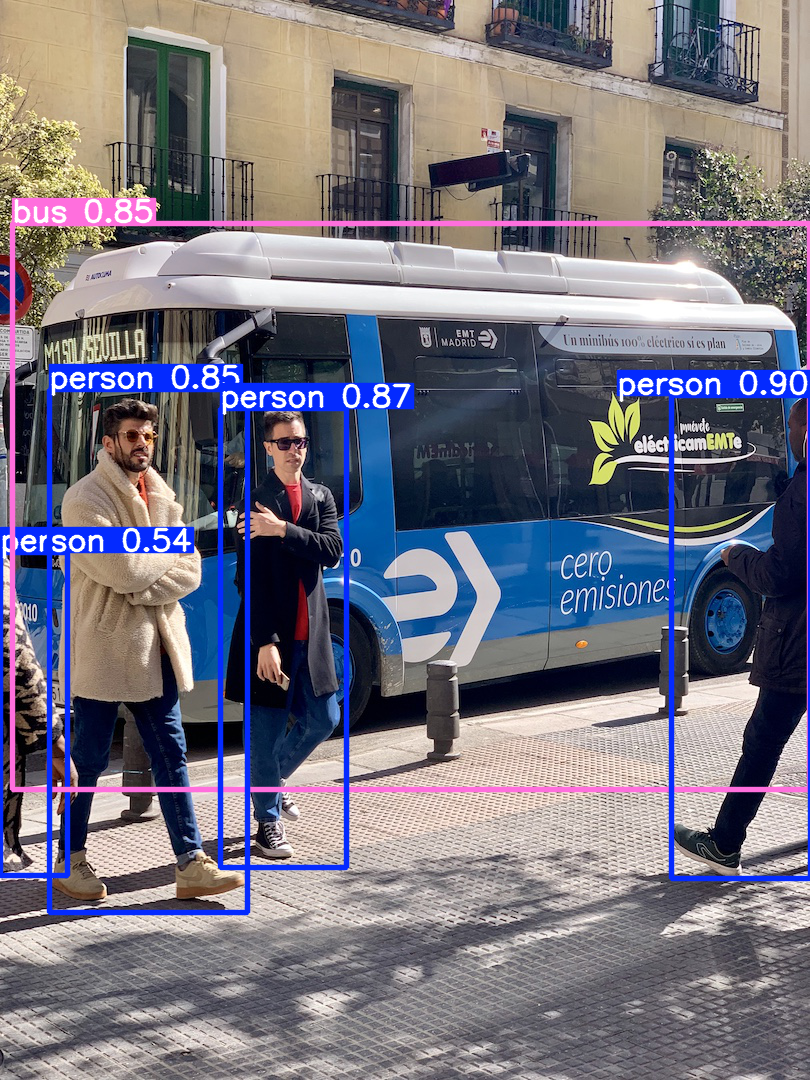

In [3]:
import cv2
import torch
model = torch.hub.load('./', 'yolov5s', source='local', pretrained=True)
img = './data/images/bus.jpg'
results = model(img)
results.show()

In [1]:
import cv2
import numpy as np
import openvino.runtime as ov

class OpenvinoInfer:
    def __init__(self, model_path, device="CPU", conf_threshold=0.5, nms_threshold=0.45):
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold

        # Load the OpenVINO model
        core = ov.Core()
        self.model = core.read_model(model=model_path)
        self.compiled_model = core.compile_model(model=self.model, device_name=device)
        self.input_layer = self.compiled_model.input(0)
        self.output_layer = self.compiled_model.output(0)
        
        # Get input shape
        self.input_shape = self.input_layer.shape  # [1, 3, 640, 640] if YOLOv5 default input
        self.input_height, self.input_width = self.input_shape[2], self.input_shape[3]

    def preprocess(self, frame):
        # Resize and letterbox to keep the aspect ratio
        img = cv2.resize(frame, (self.input_width, self.input_height), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize to [0, 1]
        img = np.transpose(img, (2, 0, 1))  # Change data layout from HWC to CHW
        img = np.expand_dims(img, axis=0).astype(np.float32)  # Add batch dimension
        return img

    def postprocess(self, output, frame):
        # Retrieve boxes and filter by confidence
        boxes, confidences, class_ids = [], [], []
        rows = output.shape[1]
        
        for i in range(rows):
            row = output[0][i]
            confidence = row[4]
            if confidence >= self.conf_threshold:
                # Extract box and class score
                x, y, w, h = row[:4]
                class_scores = row[5:]
                class_id = np.argmax(class_scores)
                class_score = class_scores[class_id]
                final_confidence = confidence * class_score

                # Filter out low confidence predictions
                if final_confidence > self.conf_threshold:
                    # Convert box to (x1, y1, x2, y2) format
                    x1 = int((x - w / 2) * frame.shape[1])
                    y1 = int((y - h / 2) * frame.shape[0])
                    x2 = int((x + w / 2) * frame.shape[1])
                    y2 = int((y + h / 2) * frame.shape[0])

                    boxes.append([x1, y1, x2 - x1, y2 - y1])
                    confidences.append(float(final_confidence))
                    class_ids.append(class_id)
        
        # Perform non-maximum suppression to remove duplicate boxes
        indices = cv2.dnn.NMSBoxes(boxes, confidences, self.conf_threshold, self.nms_threshold)
        result_boxes = [boxes[i[0]] for i in indices]
        result_confidences = [confidences[i[0]] for i in indices]
        result_class_ids = [class_ids[i[0]] for i in indices]
        
        return result_boxes, result_confidences, result_class_ids

    def infer(self, frame):
        # Preprocess the input frame
        input_data = self.preprocess(frame)

        # Run inference
        result = self.compiled_model([input_data])[self.output_layer]

        # Postprocess to get boxes, confidences, and class_ids
        boxes, confidences, class_ids = self.postprocess(result, frame)
        
        # Draw bounding boxes on the original frame
        for (box, confidence, class_id) in zip(boxes, confidences, class_ids):
            x, y, w, h = box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"Class {class_id}: {confidence:.2f}"
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        return frame

# 初始化模型路径和设备
model_path = "/home/zz/yolov5/runs/train/exp/weights/best.onnx"
openvino_infer = OpenvinoInfer(model_path, device="CPU")

# 打开摄像头
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 进行推理并显示结果
    frame = openvino_infer.infer(frame)
    cv2.imshow("OpenVINO Detection", frame)

    # 按下 'q' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Error: Could not open video.


[ WARN:0@0.209] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.327] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
